In [97]:
import serial.tools.list_ports
import pprint

port_data = []

for port in serial.tools.list_ports.comports():
    info = dict({"Name": port.device, "Description": port.description, "Manufacturer": port.manufacturer,
                 "Hwid": port.hwid})
    port_data.append(info)
pprint.pprint (port_data)



[{'Description': 'n/a',
  'Hwid': 'n/a',
  'Manufacturer': None,
  'Name': '/dev/cu.wlan-debug'},
 {'Description': 'n/a',
  'Hwid': 'n/a',
  'Manufacturer': None,
  'Name': '/dev/cu.Bluetooth-Incoming-Port'},
 {'Description': 'USB Serial',
  'Hwid': 'USB VID:PID=1A86:7523 LOCATION=0-1.1',
  'Manufacturer': None,
  'Name': '/dev/cu.usbserial-110'}]


In [92]:
import serial
import time
# Configure the serial connections
# You might need to change the COM port name and the baud rate

ser = serial.Serial(
    port='/dev/cu.usbserial-110',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)
ser.read_all()
ser.close()

In [43]:
ser.write(b'\xff\xff\x00\x55\x55')

5

In [41]:
tx_str="hello world."
hex_data=bytes(tx_str,'utf-8').hex()
print(type((hex_data)))
ser.write(bytes.fromhex(hex_data))

<class 'str'>


12

In [98]:
import serial
import time
import math
from collections import deque
# Configure the serial connections
# You might need to change the COM port name and the baud rate

ser = serial.Serial(
    port='/dev/cu.usbserial-110',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)

t1=time.time()
data_points = deque(maxlen=1000)
data_receice=[]
is_start=False
is_len=False
is_data=False
head_padding=0
k=0
# Main loop to read data from the COM port
try:
    while True:
        if ser.in_waiting >= 4:  # Check if at least 4 bytes are in the buffer
            # Read 4 bytes from the serial port
            data = ser.read(4)
            # Convert bytes to uint32_t (adjust 'little' or 'big' based on your device)
            number = int.from_bytes(data, byteorder='little', signed=False)
            data_points.append(number)
            min_val=min(data_points)
            max_val=max(data_points)
            mid_val=(min_val+max_val)/2
            if is_start is False and number<mid_val:
                head_padding+=1
                if head_padding==16:
                    is_start=True
            elif is_start is False and number>=mid_val:
                head_padding=0
            
            if is_start and is_len is False:
                if number>mid_val:
                    pass
            k+=1
            if k%1==0:
                print(time.time()-t1)
                t1=time.time()

            # print(f"ADC value received: {min_val,max_val}")

except KeyboardInterrupt:
    print("Exiting program")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    ser.close()
    print("Serial connection closed")



0.002412080764770508
0.005023956298828125
0.00603485107421875
0.005961179733276367
0.006072044372558594
0.005897045135498047
0.005975961685180664
0.0060040950775146484
0.00568389892578125
0.006177663803100586
0.005934715270996094
0.006020069122314453
0.0059850215911865234
0.005978107452392578
0.005950927734375
0.0059719085693359375
0.0059893131256103516
0.005965232849121094
0.005987882614135742
0.005992889404296875
0.0059299468994140625
0.005990028381347656
0.0065288543701171875
0.007065773010253906
0.0041828155517578125
0.0057659149169921875
0.005964994430541992
0.005967140197753906
0.006129026412963867
0.005970954895019531
0.006002902984619141
0.005897998809814453
0.00597691535949707
0.0060100555419921875
0.00593876838684082
0.006009101867675781
0.006011962890625
0.005906820297241211
0.005972862243652344
0.005991935729980469
0.005933046340942383
0.005959987640380859
0.0060079097747802734
0.0064849853515625
0.005486965179443359
0.006136178970336914
0.006072044372558594
0.0059020519256

In [34]:
import threading
import serial
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
# %matplotlib notebook

# Set up the serial port (for example, COM3, 9600 baud rate)
ser = serial.Serial(
    port='/dev/cu.usbserial-110',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)

# Deque for storing data points
data_points = deque(maxlen=200)
data_lock = threading.Lock()  # Thread lock for safe data access

def read_from_port(ser):
    print("Start read port:")
    try:
        while True:
            if ser.in_waiting >= 4:
                data = ser.read(4)
                number = int.from_bytes(data, byteorder='little', signed=False)
                
                with data_lock:  # Acquire lock to update data_points
                    data_points.append(number)
    except KeyboardInterrupt:
        print("Exiting program")
        
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        ser.close()
        print("Serial connection closed")

def animate(i):
    with data_lock:
        if data_points:
            line.set_data(range(len(data_points)), list(data_points))
            ax.relim()  # Recalculate limits
            ax.autoscale_view()  # Auto-scale
        print(data_points)
    return line,

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot(data_points)
ax.set_xlim(0, 200)
ax.set_ylim(0, 4095)  # Adjust based on your ADC resolution

# Start the thread for reading serial data
thread = threading.Thread(target=read_from_port, args=(ser,))
thread.daemon = True
thread.start()

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, interval=100, blit=True)

plt.show()

SerialException: [Errno 2] could not open port /dev/cu.usbserial-110: [Errno 2] No such file or directory: '/dev/cu.usbserial-110'

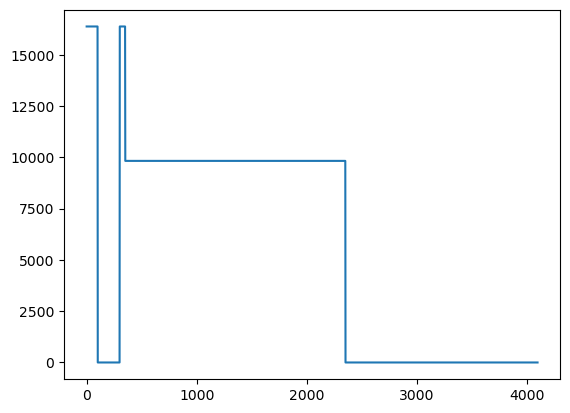

In [36]:
import numpy as np

def quantize_to_DAC(voltages, upper_voltage, lower_voltage):
    # This function quantizes a series of voltages to 14-bit DAC values.

    # Parameters:
    # voltages: A one-column array of voltages to be quantized.
    # upper_voltage: The upper limit of the voltage range.
    # lower_voltage: The lower limit of the voltage range.

    # Returns:
    # A NumPy array of the same size as voltages, with quantized 14-bit unsigned integer values.

    # Define the resolution of the DAC
    dac_resolution = 2**14 - 1  # 14-bit resolution
    
    # Check for voltages outside the input range and output a warning
    if np.any(voltages < lower_voltage) or np.any(voltages > upper_voltage):
        print('Warning: Some voltages will be clipped.')

    # Scale and shift the voltages to fit into the range [0, dac_resolution]
    scaled_voltages = (voltages - lower_voltage) / (upper_voltage - lower_voltage) * dac_resolution

    # Quantize and clip the values to ensure they fit within the 14-bit range
    quantized_voltages = np.uint16(np.clip(scaled_voltages, 0, dac_resolution))
    
    return quantized_voltages

# Create a simple ramp function for the arbitrary waveform generator
voltages = np.ones(4096) * (-5)
voltages[:100] = 5
voltages[100:300] = -5
voltages[300:350] = 5
voltages[350:2350] = 1

quantized_voltages = quantize_to_DAC(voltages, 5, -5)

# Plot the quantized voltages (optional)
import matplotlib.pyplot as plt
plt.plot(quantized_voltages)
plt.show()

Filename = 't2.rdf'  # Store in this file
with open(Filename, 'wb') as fid:  # Open the file for writing in binary mode
    fid.write(quantized_voltages.tobytes())  # Write as 16-bit values, little endian
